In [42]:
# https://www.sktime.net/en/v0.24.1/examples/transformation/rocket.html
from sktime.datatypes import check_raise, convert_to
from sktime.transformations.panel.rocket import Rocket, MiniRocket, MiniRocketMultivariate, MultiRocketMultivariate
from sktime.transformations.panel.summarize import RandomIntervalFeatureExtractor
from sktime.transformations.series.impute import Imputer
from sktime.classification.interval_based import TimeSeriesForestClassifier
from sktime.regression.interval_based import TimeSeriesForestRegressor
from sktime.classification.ensemble import ComposableTimeSeriesForestClassifier
from sktime.transformations.panel.compose import ColumnConcatenator
from sklearn.model_selection import KFold

from matplotlib import pyplot as plt
from sktime.utils.plotting import plot_series
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeClassifierCV, RidgeCV, SGDClassifier, SGDRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC, LinearSVR
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import ipywidgets as widgets
import numpy as np
import glob
import pandas as pd
import os
from sktime.pipeline import make_pipeline

In [43]:
def load_individual_instance(filename, needed_columns):
    df = pd.read_csv(filename)
    for col in needed_columns:
         if not (col in df.columns):
            df[col] = 0.0
    # Ensure all the columns are in the correct order
    return df[needed_columns]    

In [44]:
def create_combined_data(base_dir, filenames, needed_columns):
    combined_data_m = map(lambda file: load_individual_instance(base_dir + "/" + file, needed_columns), filenames)
    combined_data = list(combined_data_m)
    print("Check data: ",check_raise(combined_data, mtype="df-list")) 
    return combined_data

In [45]:
def single_metric_value(m, divisor):
    f = np.floor(m/divisor)
    if (f < 0):
        return 0.0
    else:
        return f

In [46]:
def read_data(results_directory, mfile):
    data_files = list(map(os.path.basename, sorted(glob.glob(results_directory + "/MODELFILE*"))))
    metrics = pd.read_csv(mfile)
    return data_files, metrics

In [47]:
def rocket_regression(base_dir, data_files_train, data_files_test, metrics_train_pandas, metrics_test_pandas, target_metric_name):
    train_data = create_combined_data(base_dir, data_files_train, needed_columns)
    test_data = create_combined_data(base_dir, data_files_test, needed_columns)
    metrics_train = np.array(metrics_train_pandas[target_metric_name])
    metrics_test =  np.array(metrics_test_pandas[target_metric_name])

    print(metrics_train)
    
    print("Check data format train_metrics: ",check_raise(metrics_test, mtype="np.ndarray"))
    print("Check data format test_metrics: ",check_raise(metrics_train, mtype="np.ndarray"))
    
    rocket_pipeline = make_pipeline(RandomIntervalFeatureExtractor(), StandardScaler(with_mean=False), RidgeCV(alphas=(0.1, 1.0, 50.0))) 
    rocket_pipeline.fit(train_data, metrics_train)
    print("ROCKET fit done!")
    score = rocket_pipeline.score(test_data, metrics_test)
    
    print("Score on test data = ",score)
    print("ROCKET score done!")

    predicted_val = rocket_pipeline.predict(test_data)
    actual_val = metrics_test
    predicted_vs_actual = pd.DataFrame({'predicted_val':predicted_val, 'actual_val':actual_val}, columns = ['predicted_val', 'actual_val'])
    return [rocket_pipeline, predicted_vs_actual]

In [48]:
def tsf_regression(base_dir, data_files_train, data_files_test, metrics_train_pandas, metrics_test_pandas, target_metric_name):
    train_data = create_combined_data(base_dir, data_files_train, needed_columns)
    test_data = create_combined_data(base_dir, data_files_test, needed_columns)
    metrics_train = np.array(metrics_train_pandas[target_metric_name])
    metrics_test =  np.array(metrics_test_pandas[target_metric_name])

    print(metrics_train)
    
    print("Check data format train_metrics: ",check_raise(metrics_test, mtype="np.ndarray"))
    print("Check data format test_metrics: ",check_raise(metrics_train, mtype="np.ndarray"))

    combiner = ColumnConcatenator()
    tsfr = combiner * TimeSeriesForestRegressor(n_estimators=20, n_jobs=-1)
    tsfr.fit(train_data, metrics_train)
    print("TSR fit done!")
    score = tsfr.score(test_data, metrics_test)
    
    print("Score on test data = ",score)
    print("TSR score done!")

    predicted_val = tsfr.predict(test_data)
    actual_val = metrics_test
    predicted_vs_actual = pd.DataFrame({'predicted_val':predicted_val, 'actual_val':actual_val}, columns = ['predicted_val', 'actual_val'])
    return [tsfr, predicted_vs_actual]

In [49]:
def metricval_to_class(metric_vals, metric_max, metric_min, bin_count):
    bins = np.linspace(metric_min, metric_max, bin_count+1)
    digitized = np.digitize(metric_vals, bins)
    return digitized

In [50]:
def tsf_classifier(base_dir, data_files_train, data_files_test, metrics_train_pandas, metrics_test_pandas, target_metric_name, num_kernels, class_count):
    train_data = create_combined_data(base_dir, data_files_train, needed_columns)
    test_data = create_combined_data(base_dir, data_files_test, needed_columns)
    metrics_train = np.array(metrics_train_pandas[target_metric_name])
    metrics_test =  np.array(metrics_test_pandas[target_metric_name])
    print(metrics_train)
    
    print("Check data format train_metrics: ",check_raise(metrics_test, mtype="np.ndarray"))
    print("Check data format test_metrics: ",check_raise(metrics_train, mtype="np.ndarray"))
    
    metric_max = np.max([np.max(metrics_train), np.max(metrics_test)])
    metric_min = np.min([np.min(metrics_train), np.min(metrics_test)])
    print(metric_max)
    print(metric_min)
    train_class = metricval_to_class(metrics_train, metric_max, metric_min, class_count)
    test_class = metricval_to_class(metrics_test, metric_max, metric_min, class_count)
    print(train_class)
    print(test_class)
    
    print("Check data format train_metrics: ", check_raise(train_class, mtype="np.ndarray"))
    print("Check data format test_metrics: ", check_raise(test_class, mtype="np.ndarray"))

    combiner = ColumnConcatenator()
    tsfc = combiner * TimeSeriesForestClassifier(n_estimators=5)
    tsfc.fit(train_data, train_class)
    print("TSF classifier fit done!")
    score = tsfc.score(test_data, test_class)
    print("Score on test data = ",score)
    print("TSF classifier score done!")
    predicted_class = tsfc.predict(test_data)
    actual_class = test_class
    # Not sure why have to take index 0 here
    #diff_ids = np.where((predicted_class-actual_class) != 0)[0]
    class_diff = predicted_class-actual_class
    diff_ids = np.where(abs(class_diff) > 1)[0]
    
    diff_names = np.array(data_files_test)[diff_ids]
    diffs = pd.DataFrame({'diff_id':diff_ids, 'diff_names':diff_names, 'predicted_class':predicted_class[diff_ids], 'actual_class':actual_class[diff_ids]}, columns=["diff_id", "diff_names", "predicted_class", "actual_class"])
    #diffs = pd.DataFrame({'diff_id':diff_ids, 'diff_names':diff_names}, columns=["diff_ids", "diff_names"])
    predicted_vs_actual = pd.DataFrame({'predicted_class':predicted_class, 'actual_class':actual_class}, columns = ['predicted_class', 'actual_class'])
    return [tsfc, predicted_vs_actual, diffs]

In [51]:
base_dir = "./temp-data-variable-multimodels/"
metric_name = "distanceToPoint3D"

needed_columns = ['distortVelocity_variable', "reverseVehicle_variable"]
mfile = base_dir + "metrics.csv"
rocket_num_kernels = 10000

In [52]:
data_files, metrics = read_data(base_dir, mfile)
data_files_train, data_files_test, metrics_train, metrics_test = train_test_split(data_files, metrics, test_size=0.2, random_state=0)
print(len(data_files_train))
print(len(metrics_train))

1611
1611


In [53]:
def check_match(data_files, metrics):
    matches = (metrics["testName"] == data_files)
    return all(matches)

In [54]:
data_files, metrics = read_data(base_dir, mfile)
data_files_train, data_files_test, metrics_train, metrics_test = train_test_split(data_files, metrics, test_size=0.2, random_state=0)
operations_log = pd.read_csv(base_dir + "/operationAndMetricLog.csv")
if (check_match(data_files_train, metrics_train) and check_match(data_files_test, metrics_test)):
    print("All test/train names match OK!")
    rocket_reg, predicted_vs_actual = tsf_regression(base_dir, data_files_train, data_files_test, metrics_train, metrics_test, metric_name)
    predicted_vs_actual

All test/train names match OK!
Check data:  True
Check data:  True
[2.75529234 1.38316498 3.00723532 ... 0.23557489 1.41620308 2.20926866]
Check data format train_metrics:  True
Check data format test_metrics:  True


/home/simtesting/python-venvs/sktime/lib/python3.8/site-packages/sktime/base/_base_panel.py:313: UserWarning: Data seen by RegressorPipeline instance has multivariate series, but this RegressorPipeline instance cannot handle multivariate series. Calls with multivariate series may result in error or unreliable results.
  warn(msg, obj=self)


TSR fit done!


/home/simtesting/python-venvs/sktime/lib/python3.8/site-packages/sktime/base/_base_panel.py:313: UserWarning: Data seen by RegressorPipeline instance has multivariate series, but this RegressorPipeline instance cannot handle multivariate series. Calls with multivariate series may result in error or unreliable results.
  warn(msg, obj=self)


Score on test data =  0.6383930442061998
TSR score done!


/home/simtesting/python-venvs/sktime/lib/python3.8/site-packages/sktime/base/_base_panel.py:313: UserWarning: Data seen by RegressorPipeline instance has multivariate series, but this RegressorPipeline instance cannot handle multivariate series. Calls with multivariate series may result in error or unreliable results.
  warn(msg, obj=self)


In [55]:
from sktime.performance_metrics.forecasting import MeanAbsoluteError
from sktime.performance_metrics.forecasting import median_absolute_percentage_error

SHORT_MIN_THRESHOLD = 2
test_file_stats = operations_log.loc[operations_log["testID"].isin(data_files_test)]
test_file_stats_minfuzztime = pd.to_numeric(test_file_stats["minFuzzingTime"], errors="coerce")
test_file_stats_fuzztime = pd.to_numeric(test_file_stats["fuzzingTimeSet"], errors="coerce")
vel_ops_count = pd.to_numeric(test_file_stats["vel_ops"], errors="coerce")
rv_ops_count = pd.to_numeric(test_file_stats["rv_ops"], errors="coerce")
colormap = np.array(['b', 'r', 'g', 'purple', 'yellow', 'black', 'grey', 'orange'])
is_short = (test_file_stats_minfuzztime < SHORT_MIN_THRESHOLD).astype(int)
has_multiple_vel_ops = (vel_ops_count > 1).astype(int)
has_multiple_rv_ops = (rv_ops_count > 1).astype(int)
# Color as blue or red depending on the presence of short operation or not
color_code = is_short

/home/simtesting/python-venvs/sktime/lib/python3.8/site-packages/sktime/performance_metrics/forecasting/_classes.py:614: UserWarning: y_pred and y_true do not have the same column index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(


r2_score =  0.6383930442061998
MSE =  0.5205434746611682
RMSE =  0.7214869885598549


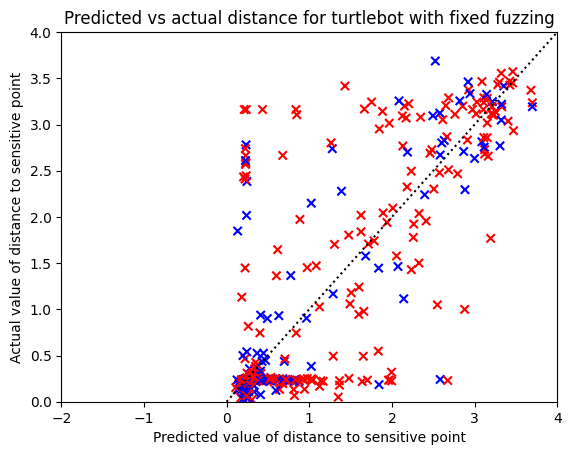

In [58]:
from sklearn.metrics import r2_score
from sktime.performance_metrics.forecasting import MeanSquaredError

mse_c = MeanSquaredError()
rmse_c = MeanSquaredError(square_root=True)

r2_score_val = r2_score(predicted_vs_actual["actual_val"], predicted_vs_actual["predicted_val"], multioutput="uniform_average")
mse_val = mse_c(predicted_vs_actual["actual_val"], predicted_vs_actual["predicted_val"])
rmse_val = rmse_c(predicted_vs_actual["actual_val"], predicted_vs_actual["predicted_val"])
print("r2_score = ", r2_score_val)
print("MSE = ", mse_val)
print("RMSE = ", rmse_val)

plt.scatter(predicted_vs_actual["predicted_val"], predicted_vs_actual["actual_val"], c=colormap[color_code], marker="x")
plt.axline((1,1),(2,2), marker="None", linestyle="dotted", color="Black")
plt.xlabel("Predicted value of distance to sensitive point")
plt.ylabel("Actual value of distance to sensitive point")
plt.xlim([-2, 4.0])
plt.ylim([0, 4.0])
plt.title("Predicted vs actual distance for turtlebot with fixed fuzzing");
plt.savefig("fixedfuzzing_multimodels_twooperations_turtlebot.pdf")

Filtered points count: 124
r2_score =  0.6534493743280487
MSE =  0.3824963221003844
RMSE =  0.6184628704298945


/home/simtesting/python-venvs/sktime/lib/python3.8/site-packages/sktime/performance_metrics/forecasting/_classes.py:614: UserWarning: y_pred and y_true do not have the same column index. This may indicate incorrect objects passed to the metric. Indices of y_true will be used for y_pred.
  warn(


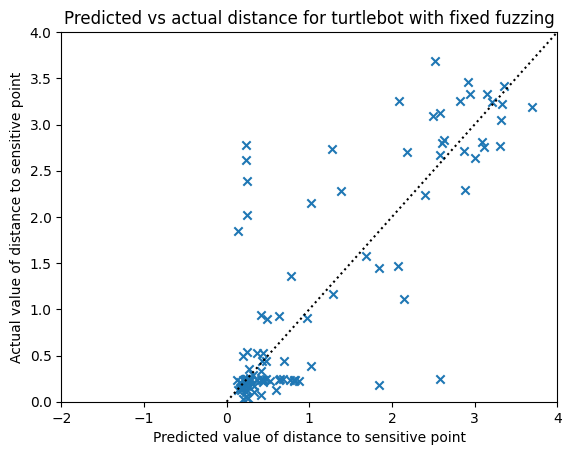

In [60]:
from sklearn.metrics import r2_score
from sktime.performance_metrics.forecasting import MeanSquaredError

bpt = is_short==0
blue_points = predicted_vs_actual.loc[np.array(bpt)]
print("Filtered points count:", len(blue_points))

plt.scatter(blue_points["predicted_val"], blue_points["actual_val"], marker="x")
plt.axline((1,1),(2,2), marker="None", linestyle="dotted", color="Black")
plt.xlabel("Predicted value of distance to sensitive point")
plt.ylabel("Actual value of distance to sensitive point")
plt.xlim([-2, 4.0])
plt.ylim([0, 4.0])
plt.title("Predicted vs actual distance for turtlebot with fixed fuzzing");
#mae = MeanAbsoluteError()
mse_c = MeanSquaredError()
rmse_c = MeanSquaredError(square_root=True)

r2_score_val = r2_score(blue_points["predicted_val"], blue_points["actual_val"])
mse_val = mse_c(blue_points["predicted_val"], blue_points["actual_val"])
rmse_val = rmse_c(blue_points["predicted_val"], blue_points["actual_val"])
print("r2_score = ", r2_score_val)
print("MSE = ", mse_val)
print("RMSE = ", rmse_val)
plt.savefig("fixedfuzzing_multimodels_twooperations_turtlebot_filtered.pdf")

In [113]:
metric_class_count = 3
data_files, metrics = read_data(base_dir, mfile)
data_files_train, data_files_test, metrics_train, metrics_test = train_test_split(data_files, metrics, test_size=0.2, random_state=0)
if (check_match(data_files_train, metrics_train) and check_match(data_files_test, metrics_test)):
    print("All test/train names match OK!")
    rocket_cl, predicted_vs_actual, diffs = tsf_classifier(base_dir, data_files_train, data_files_test, metrics_train, metrics_test, metric_name, num_kernels, metric_class_count)
    diffs    

All test/train names match OK!
Check data:  True
Check data:  True
[2.75529234 1.38316498 3.00723532 ... 0.23557489 1.41620308 2.20926866]
Check data format train_metrics:  True
Check data format test_metrics:  True
3.7045065957994514
0.0223194991237505
[3 2 3 ... 1 2 2]
[1 1 1 3 3 1 1 1 2 1 1 1 1 1 3 1 2 1 1 3 1 1 1 1 1 1 3 1 1 3 1 1 1 2 3 1 1
 1 1 3 1 1 1 1 3 1 3 3 1 1 3 3 3 3 1 1 1 1 1 1 1 3 1 1 3 1 3 3 3 1 2 1 3 1
 2 1 3 3 1 1 1 1 3 1 1 2 1 1 1 1 1 1 1 3 1 1 1 3 3 1 1 3 3 1 1 2 1 1 1 1 1
 3 1 3 1 1 3 1 1 1 2 3 1 1 3 1 3 1 1 1 1 3 1 1 1 3 1 1 1 3 1 1 1 1 2 1 3 1
 1 1 1 1 1 1 2 2 1 1 3 3 2 1 1 1 1 3 1 2 3 3 1 1 1 1 3 1 2 1 1 1 2 3 1 1 1
 3 1 1 1 1 1 1 3 1 1 2 1 2 1 1 1 1 1 1 3 1 3 1 1 1 1 1 1 2 1 3 1 1 1 2 1 3
 1 1 1 1 2 1 1 1 2 1 1 1 3 1 1 1 2 1 3 1 1 1 1 1 1 1 1 2 1 2 1 1 1 3 1 3 1
 1 1 1 2 1 1 1 1 1 1 1 1 3 1 3 2 1 1 1 3 1 3 1 3 1 3 1 1 1 1 2 1 1 3 1 3 3
 3 1 1 1 1 1 3 2 1 2 1 1 2 1 1 3 1 2 3 1 3 3 1 1 1 1 1 3 1 3 1 1 1 2 1 3 1
 1 1 1 3 3 1 2 2 1 1 1 1 1 1 1 3 3 1 1 3 2 1 1 3 1 2 

/home/simtesting/python-venvs/sktime/lib/python3.8/site-packages/sktime/base/_base_panel.py:313: UserWarning: Data seen by ClassifierPipeline instance has multivariate series, but this ClassifierPipeline instance cannot handle multivariate series. Calls with multivariate series may result in error or unreliable results.
  warn(msg, obj=self)


TSF classifier fit done!


/home/simtesting/python-venvs/sktime/lib/python3.8/site-packages/sktime/base/_base_panel.py:313: UserWarning: Data seen by ClassifierPipeline instance has multivariate series, but this ClassifierPipeline instance cannot handle multivariate series. Calls with multivariate series may result in error or unreliable results.
  warn(msg, obj=self)


Score on test data =  0.8337468982630273
TSF classifier score done!


/home/simtesting/python-venvs/sktime/lib/python3.8/site-packages/sktime/base/_base_panel.py:313: UserWarning: Data seen by ClassifierPipeline instance has multivariate series, but this ClassifierPipeline instance cannot handle multivariate series. Calls with multivariate series may result in error or unreliable results.
  warn(msg, obj=self)


In [114]:
diffs

,diff_id,diff_names,predicted_class,actual_class
0,13,MODELFILE1_Test_440_29_11_2024_16_46_33,3,1
1,32,MODELFILE3_Test_184_26_11_2024_08_35_53,3,1
2,46,MODELFILE1_Test_163_29_11_2024_09_27_54,1,3
3,47,MODELFILE2_Test_427_02_12_2024_04_44_02,1,3
4,51,MODELFILE1_Test_755_30_11_2024_01_40_42,1,3
5,61,MODELFILE1_Test_034_29_11_2024_05_48_33,1,3
6,66,MODELFILE1_Test_486_29_11_2024_18_34_57,1,3
7,76,MODELFILE1_Test_123_29_11_2024_07_38_47,1,3
8,91,MODELFILE1_Test_553_29_11_2024_20_20_04,3,1
9,101,MODELFILE1_Test_515_29_11_2024_19_25_20,1,3


In [66]:
predicted_vs_actual

,predicted_class,actual_class
0,1,1
1,1,1
2,1,1
3,3,3
4,3,3
...,...,...
398,1,1
399,1,2
400,2,2
401,1,1


In [69]:
def plot_cm(norm="all"):
    cm = confusion_matrix(predicted_vs_actual["actual_class"], predicted_vs_actual["predicted_class"], labels=[1,2,3], normalize=norm)
    cmd = ConfusionMatrixDisplay(cm)
    plt.rcParams.update({'font.size': 12, 'font.weight': 'bold'})
    cmd.plot()   
    

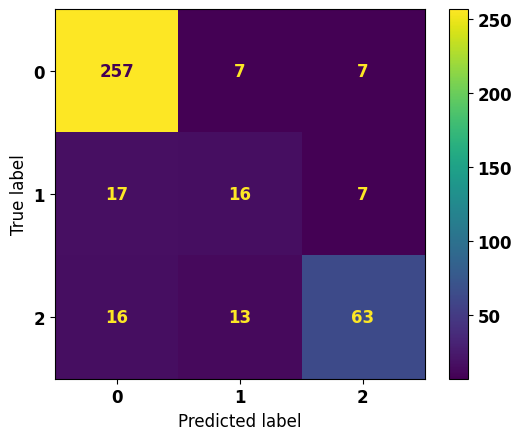

In [71]:
plot_cm(norm=None)

In [89]:
len(predicted_vs_actual)

403

In [90]:
(257+16+63)/403

0.8337468982630273

In [125]:
def correct_predictions(pred_vs_actual):
    t = len(pred_vs_actual[(predicted_vs_actual["actual_class"]==pred_vs_actual["predicted_class"])])
    return t

In [127]:
correct_predictions(predicted_vs_actual) / len(predicted_vs_actual)

0.8287841191066998

In [129]:
252/(252+17+17)

0.8811188811188811

In [130]:
66/(7+7+66)

0.825

In [131]:
16 / (16+12+9)

0.43243243243243246

In [58]:
pd.options.display.max_columns = None
pd.set_option('display.max_rows', 1000)
md = pd.read_csv("/tmp/operationAndMetricLog.csv")
md

,testID,metricValue,rv_start,rv_end,rv_intensity,vel_start,vel_end,vel_intensity
0,Test_001_26_11_2024_03_53_49,1.762991,36.560064,47.330937,0.212117,29.669841,46.400978,0.659818
1,Test_002_26_11_2024_03_53_49,2.922015,33.427812,46.738944,0.515883,45.640690,46.997916,0.544485
2,Test_003_26_11_2024_03_53_49,0.154625,38.247693,41.293853,0.892699,45.062123,47.553375,0.181511
3,Test_004_26_11_2024_03_53_49,0.913575,32.695946,46.212032,0.862032,37.078571,47.787349,0.797909
4,Test_005_26_11_2024_03_53_49,0.236341,32.192160,34.479396,0.236694,37.103515,38.852693,0.137887
5,Test_006_26_11_2024_03_53_49,0.026972,44.653881,45.759877,0.778396,36.275321,39.189332,0.926581
6,Test_007_26_11_2024_03_53_49,1.768129,28.116696,40.209193,0.322163,43.780570,46.075038,0.156790
7,Test_008_26_11_2024_03_53_49,0.457485,29.682578,40.264113,0.941578,25.852432,41.166348,0.855842
8,Test_009_26_11_2024_03_53_49,0.615969,26.406808,32.807220,0.882918,28.891786,43.525360,0.452632
9,Test_010_26_11_2024_03_53_49,0.229249,41.951408,44.608889,0.182062,37.845604,47.178471,0.777765
